### Final model evaluation on the test set

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (f1_score, roc_auc_score, recall_score,
                             precision_score, accuracy_score, 
                             average_precision_score, roc_curve,
                             auc, precision_recall_curve, confusion_matrix,
                             classification_report)

import warnings
warnings.filterwarnings('ignore')

# Config
pd.set_option('display.max_columns', None)


In [3]:
# Best hyperparameters from hyperparameter tuning
best_params = {
    'n_estimators': 400,
    'max_depth': 5,
    'learning_rate': 0.1,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.9,
    'gamma': 0,
    'reg_alpha': 0.5,
    'reg_lambda': 2,
    'scale_pos_weight': 4,
    'random_state': 42,
    'eval_metric': 'logloss',
    'tree_method': 'hist'
}

final_features = ['P_ECCENTRICITY', 'P_SEMI_MAJOR_AXIS',
                       'S_MASS', 'S_TEMPERATURE', 'S_DISTANCE', 
                       'S_METALLICITY', 'P_MASS', 'P_RADIUS',
                       'P_GRAVITY','P_FLUX', 'S_LUMINOSITY',
                       'S_TIDAL_LOCK']

target = 'HABITABILITY'
group_col = 'S_NAME'
randome_state = 42

print("Exoplanet Habitability Test Set Model Evaluation")
print("\nConfigurations:")
print("model: XGBoost Classifier")
print(f"Features: {final_features}")
print(f"Target: {target}")
print(f"Group Column: {group_col}")
print(f"Random State: {randome_state}")

test_df = pd.read_csv('../data/processed/test_phl.csv')
train_df = pd.read_csv('../data/processed/train_phl.csv')

X_train = train_df[final_features]
y_train = train_df[target]
X_test = test_df[final_features]
y_test = test_df[target]

# Preprocessing Pipeline
numerical_features = X_train[final_features].select_dtypes(include=['float64', 'int64']).columns.to_list()
numerical_transformer = KNNImputer(n_neighbors=5, weights='distance')

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features)
], remainder='drop')

# Model: XGBoost Pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(**best_params))
])

# Train the Model
print(f"\nTraining the XGBoost model on {len(X_train)} samples in training set")
model.fit(X_train, y_train)

# Generate Predictions on Test Set
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(f"\nGenerate prediction on {len(X_test)} samples in test set")
print(f"\nPrediction stats:")
print(f"predicted habitable: {(y_pred==1).sum()} ({(y_pred==1).sum()/len(y_pred)*100:.1f}%)")
print(f"predicted not habitable: {(y_pred==0).sum()} ({(y_pred==0).sum()/len(y_pred)*100:.1f}%)")
print(f"Probability range:[{y_prob.min():.3f}, {y_prob.max():.3f}]")
print(f"Average predicted probability of habitable: {y_prob.mean():.3f}")
print(f"Median predicted probability of habitable: {np.median(y_prob):.3f}")


# Performance Metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)

print("\nPerformance Metrics on Test Set:")
print(f"Accuracy: {accuracy:.4f}, {accuracy*100:.2f}% correctly classified")
print(f"F1 Score: {f1:.4f}")
print(f"Recall (Sensitivity): {recall:.4f},  {recall*100:.2f}% of actual habitable planets correctly identified")
print(f"Precision: {precision:.4f},   {precision*100:.2f}% of predicted habitable planets are actually habitable")
print(f"Specificity: {specificity:.4f},  {specificity*100:.2f}% of actual not habitable planets correctly identified")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

print("\nConfusion Matrix:")
print(f"True Negatives: {tn} correctly identified not habitable planets")
print(f"False Positives: {fp} incorrectly identified habitable planets")
print(f"False Negatives: {fn} incorrectly identified not habitable planets")
print(f"True Positives: {tp} correctly identified habitable planets")

print("\nSummary:")
print(f"Total errors: {fp + fn} out of {len(y_test)} samples, which is {(fp + fn)/len(y_test)*100:.2f}% error rate.")
print(f"Success rate: {(tp+tn)/len(y_test)*100:.2f}%")



Exoplanet Habitability Test Set Model Evaluation

Configurations:
model: XGBoost Classifier
Features: ['P_ECCENTRICITY', 'P_SEMI_MAJOR_AXIS', 'S_MASS', 'S_TEMPERATURE', 'S_DISTANCE', 'S_METALLICITY', 'P_MASS', 'P_RADIUS', 'P_GRAVITY', 'P_FLUX', 'S_LUMINOSITY', 'S_TIDAL_LOCK']
Target: HABITABILITY
Group Column: S_NAME
Random State: 42

Training the XGBoost model on 3755 samples in training set

Generate prediction on 1844 samples in test set

Prediction stats:
predicted habitable: 18 (1.0%)
predicted not habitable: 1826 (99.0%)
Probability range:[0.000, 0.999]
Average predicted probability of habitable: 0.010
Median predicted probability of habitable: 0.000

Performance Metrics on Test Set:
Accuracy: 0.9984, 99.84% correctly classified
F1 Score: 0.9189
Recall (Sensitivity): 0.8947,  89.47% of actual habitable planets correctly identified
Precision: 0.9444,   94.44% of predicted habitable planets are actually habitable
Specificity: 0.9995,  99.95% of actual not habitable planets correctl

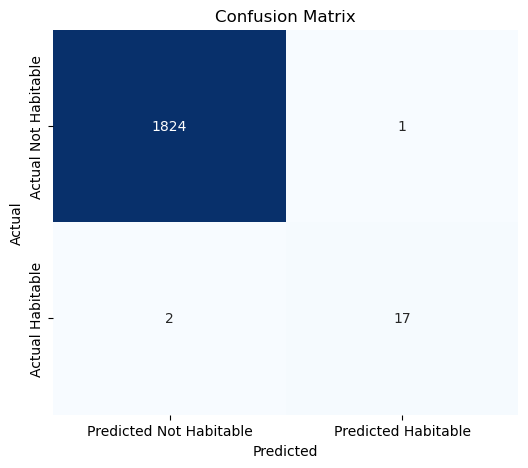

In [15]:
# Confusion Matrix Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Not Habitable', 'Predicted Habitable'],
            yticklabels=['Actual Not Habitable', 'Actual Habitable'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
# save confusion matrix plot
plt.savefig('../results/confusion_matrix.png')
plt.show()



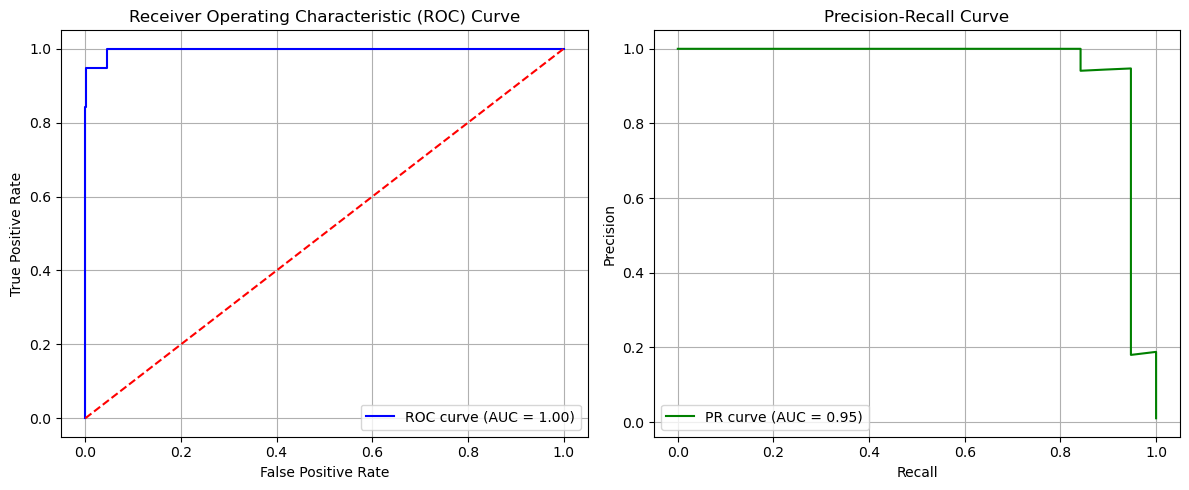

In [14]:
# ROC and PR Curves
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall_vals, precision_vals)

# ROC Curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()  

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall_vals, precision_vals, color='green', label=f'PR curve (AUC = {pr_auc:.2f})')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid()  
plt.tight_layout()
# save ROC and PR curves plot
plt.savefig('../results/roc_pr_curves.png')
plt.show()



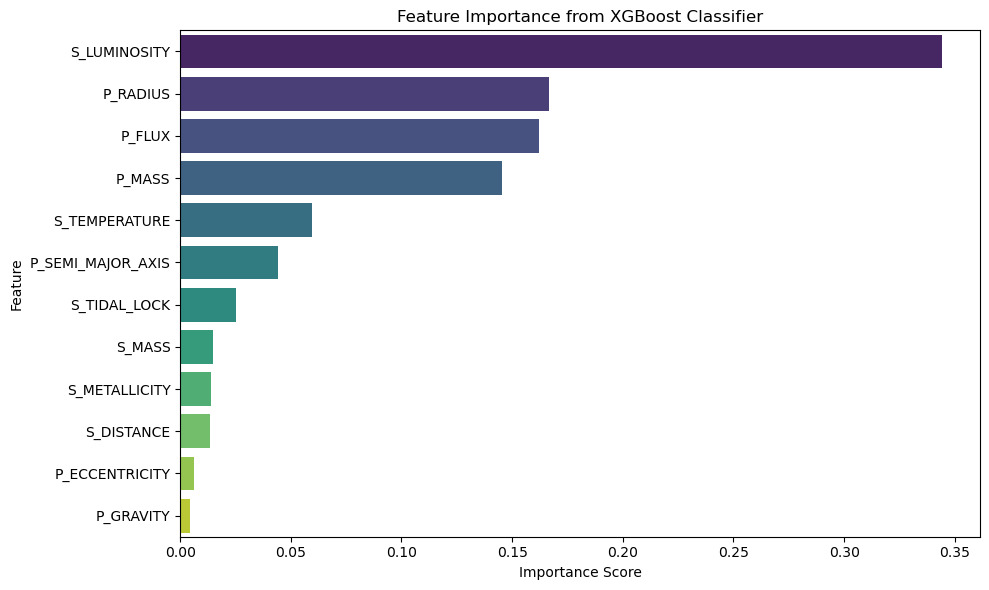

In [13]:
# Feature Importance
XGb_Classifier = model.named_steps['classifier']
feature_importances = XGb_Classifier.feature_importances_

#dataframe for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': final_features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance from XGBoost Classifier')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('../results/feature_importance.png')
plt.show()




In [12]:
# classification report
report = classification_report(y_test, y_pred, target_names=['Not Habitable', 'Habitable'])
print("\nClassification Report:")
print(report)


Classification Report:
               precision    recall  f1-score   support

Not Habitable       1.00      1.00      1.00      1825
    Habitable       0.94      0.89      0.92        19

     accuracy                           1.00      1844
    macro avg       0.97      0.95      0.96      1844
 weighted avg       1.00      1.00      1.00      1844



In [8]:
# Save model and metadata

import joblib
import json

# Save the trained model
model_filename = '../models/xgboost_habitability_model.joblib'
joblib.dump(model, model_filename)
print(f"\nTrained model saved to {model_filename}")

# Save metadata
metadata = {
    'model_info': {
        'name': 'XGBoost Classifier for Exoplanet Habitability',
        'version': '1.0',
        'author': 'MB',
        'type': 'XGBoost Classifier',
        'model_file': model_filename
        },
    'training_config': {
        'features': final_features,
        'target': target,
        'group_column': group_col,
        'random_state': randome_state,
        'best_hyperparameters': best_params
        },
    'dataset_info': {
        'total_samples': len(train_df) + len(test_df),
        'training_set_size': len(X_train),
        'test_set_size': len(X_test),
        'train_stars': len(train_df[group_col].unique()),
        'test_stars': len(test_df[group_col].unique()),
        'source': 'PHL Exoplanets Catalog',
        },
    'class_distribution_test': {
        'habitable': int((y_test==1).sum()),
        'not_habitable': int((y_test==0).sum())
        },
    'performance_metrics': {
        'accuracy': accuracy,
        'f1_score': f1,
        'recall': recall,
        'precision': precision,
        'specificity': specificity,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc
        },
    'confusion_matrix': {
        'true_negatives': int(tn),
        'false_positives': int(fp),
        'false_negatives': int(fn),
        'true_positives': int(tp)
    },

}
metadata_filename = '../models/xgboost_habitability_model_metadata.json'
with open(metadata_filename, 'w') as f:
    json.dump(metadata, f, indent=4)
print(f"Model metadata saved to {metadata_filename}")


Trained model saved to ../models/xgboost_habitability_model.joblib
Model metadata saved to ../models/xgboost_habitability_model_metadata.json
